## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [2]:
df = pd.read_csv("train.csv")
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

### Exploration

In [3]:
df.shape

(404290, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [6]:
df=df.fillna("")
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [7]:
df.is_duplicate.unique()

array([0, 1])

- Visualize the percentage of duplicate questions 

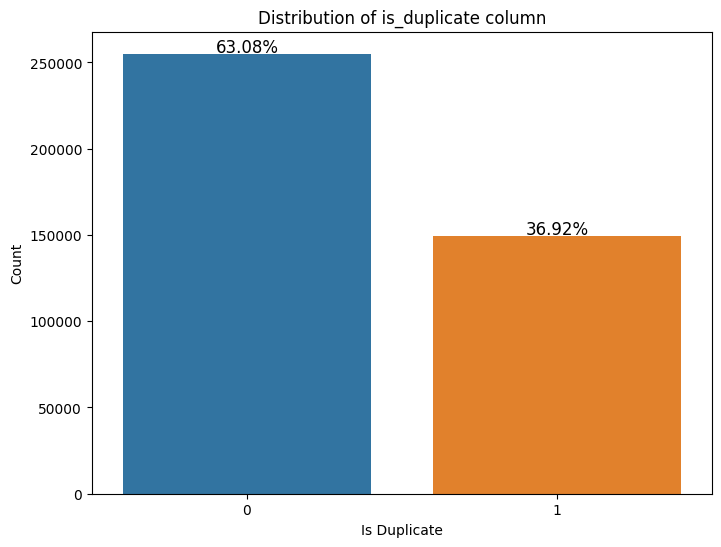

In [8]:

# Calculate count and percentage of each class
count = df['is_duplicate'].value_counts()
percentage = df['is_duplicate'].value_counts(normalize=True) * 100

# Create a new dataframe with count and percentage values
plot_data = pd.DataFrame({'count': count, 'percentage': percentage})

# Create a bar plot with seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=plot_data.index, y='count', data=plot_data)

# Add percentage values on top of the bars
for i, p in enumerate(plot_data['percentage']):
    plt.text(i, count[i] + 1000, f'{p:.2f}%', ha='center', fontsize=12)

# Set plot title, x-axis label, and y-axis label
plt.title('Distribution of is_duplicate column')
plt.xlabel('Is Duplicate')
plt.ylabel('Count')

# Show the plot
plt.show()


In [9]:
# try to balance the dataset

In [10]:
# Separate the two classes
duplicate = df[df['is_duplicate'] == 1]
non_duplicate = df[df['is_duplicate'] == 0]

# Undersample the majority class
non_duplicate_undersampled = non_duplicate.sample(len(duplicate))

# Concatenate the undersampled majority class and minority class
balanced_data = pd.concat([non_duplicate_undersampled, duplicate], axis=0)

# Shuffle the balanced dataset
balanced_data = balanced_data.sample(frac=1).reset_index(drop=True)


In [11]:
balanced_data['is_duplicate'].value_counts()

0    149263
1    149263
Name: is_duplicate, dtype: int64

### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [12]:
import warnings
warnings.filterwarnings("ignore")
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer


In [13]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leahchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/leahchen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Remove punctuation and tokenize
    text = re.findall(r'\b\w+\b', text.lower())
    
    # Remove stopwords
    text = [word for word in text if word not in stop_words]
    
    # Stemming or Lemmatization
    text = [lemmatizer.lemmatize(word) for word in text]
    
    return ' '.join(text)

df['question1'] = df['question1'].apply(clean_text)
df['question2'] = df['question2'].apply(clean_text)


In [15]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,step step guide invest share market india,step step guide invest share market,0
1,1,3,4,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,0
2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0
3,3,7,8,mentally lonely solve,find remainder math 23 24 math divided 24 23,0
4,4,9,10,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0


In [16]:
#saving to csv
df.to_csv('df_cleaned.csv', index=False)

In [17]:
# Combine 'question1' and 'question2' into a single 'text' column
df['text'] = df['question1'] + ' ' + df['question2']

In [18]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['is_duplicate'], test_size=0.2, random_state=42)

### Feature Engineering & Modeling 

#### Feature Engineering techniques: 

- tf-idf
- word2vec
- word count

#### Different modeling techniques:

- logistic regression
- XGBoost
- LSTMs

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
import gensim
from gensim.models import Word2Vec
from scipy.spatial.distance import cosine
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#### Count Vectorizer and modeling with confusion matrix

In [20]:
vect_bow = CountVectorizer()

In [21]:
X_train_bow = vect_bow.fit_transform(X_train)
X_test_bow = vect_bow.transform(X_test)

- Logistic Regression

In [22]:
# Logistic Regression model for BoW
lr_bow = LogisticRegression()
lr_bow.fit(X_train_bow, y_train)
y_pred_bow = lr_bow.predict(X_test_bow)
print("BoW Accuracy: ", accuracy_score(y_test, y_pred_bow))
print("BoW F1 Score: ", f1_score(y_test, y_pred_bow))

BoW Accuracy:  0.750290632961488
BoW F1 Score:  0.6356007146853401


- XGBoost

In [23]:
# XGBoost
xgb_model = XGBClassifier()
xgb_model.fit(X_train_bow, y_train)
xgb_predictions = xgb_model.predict(X_test_bow)
print('XGBoost Accuracy:', accuracy_score(y_test, xgb_predictions))
print('XGBoost F1 Score:', f1_score(y_test, xgb_predictions))

XGBoost Accuracy: 0.7386282124217765
XGBoost F1 Score: 0.5405652173913044


- Multinomial Naive Bayes

In [24]:
# Multinomial Naive Bayes
clf_bow = MultinomialNB()
clf_bow.fit(X_train_bow, y_train)
clf_predictions = clf_bow.predict(X_test_bow)
print('NaiveBayes Accuracy:', accuracy_score(y_test, clf_predictions))
print('NaiveBayes F1 Score:', f1_score(y_test, clf_predictions))

NaiveBayes Accuracy: 0.733718370476638
NaiveBayes F1 Score: 0.629306337482568


In [25]:
# CountVectorizer confusion matrix- logistic regression model
cm = confusion_matrix(y_test, y_pred_bow)

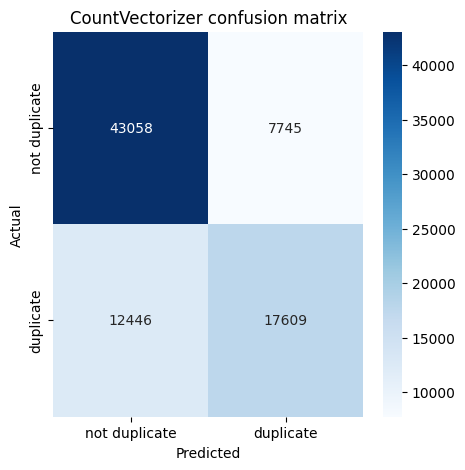

In [26]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['not duplicate','duplicate'], yticklabels=['not duplicate','duplicate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CountVectorizer confusion matrix')
plt.show()

#### TF-IDF and modeling with confusion matrix

In [27]:
# Fit a basic TFIDF Vectorizer and view the results
tfidf_vect = TfidfVectorizer(analyzer = 'word', token_pattern = r'\w{1,}', max_features = 5000, use_idf = True)


In [28]:
# TF-IDF
vect_tfidf = TfidfVectorizer()
X_train_tfidf = vect_tfidf.fit_transform(X_train)
X_test_tfidf = vect_tfidf.transform(X_test)

- Logistic Regression

In [29]:
# Logistic Regression model for TF-IDF
lr_tfidf = LogisticRegression()
lr_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)
print("TF-IDF Accuracy: ", accuracy_score(y_test, y_pred_tfidf))
print("TF-IDF F1 Score: ", f1_score(y_test, y_pred_tfidf))

TF-IDF Accuracy:  0.7515768384080734
TF-IDF F1 Score:  0.6178345160860714


- XGBoost

In [30]:
# XGBoost
xgb_model = XGBClassifier()
xgb_model.fit(X_train_tfidf, y_train)
xgb_predictions = xgb_model.predict(X_test_tfidf)
print('XGBoost Accuracy:', accuracy_score(y_test, xgb_predictions))
print('XGBoost F1 Score:', f1_score(y_test, xgb_predictions))

XGBoost Accuracy: 0.7378614360978506
XGBoost F1 Score: 0.5414900060569351


- Multinomial Naive Bayes

In [31]:
# Multinomial Naive Bayes
clf_tf = MultinomialNB()
clf_tf.fit(X_train_tfidf, y_train)
clf_tfpredictions = clf_tf.predict(X_test_tfidf)
print('NaiveBayes Accuracy:', accuracy_score(y_test, clf_tfpredictions))
print('NaiveBayes F1 Score:', f1_score(y_test, clf_tfpredictions))

NaiveBayes Accuracy: 0.736488659130822
NaiveBayes F1 Score: 0.5528342672459023


In [32]:
# TF-IDF confusion matrix - Logistic Regression Model
confusion_matrix_tf = confusion_matrix(y_test, y_pred_tfidf)

In [33]:
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['not duplicate','duplicate'], yticklabels=['not duplicate','duplicate'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

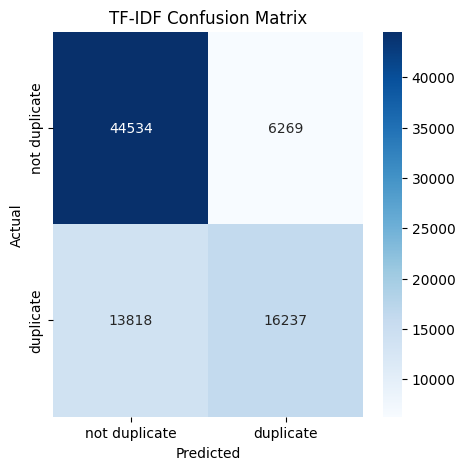

In [53]:
# TF-IDF confusion matrix
plot_confusion_matrix(confusion_matrix_tf, title='TF-IDF Confusion Matrix')

#### Word2Vec and modeling with confusion matrix

In [35]:
import gensim
from scipy.spatial.distance import cosine

In [36]:
# Prepare the corpus
corpus = pd.concat([df['question1'], df['question2']]).reset_index(drop=True)

# Tokenize the sentences
sentences = corpus.apply(lambda x: x.split())

# Train the Word2Vec model
w2v_model = Word2Vec(sentences, min_count=1, vector_size=100)


In [38]:
def sentence_vector(sentence):
    words = sentence.split()
    if len(words) == 0:
        return np.zeros(100)
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0)

In [39]:
df['w2v_question1'] = df['question1'].apply(sentence_vector)
df['w2v_question2'] = df['question2'].apply(sentence_vector)


In [40]:
def calculate_cosine_similarity(row):
    u = row['w2v_question1']
    v = row['w2v_question2']
    
    if u.ndim != 1 or v.ndim != 1:
        return np.nan
    else:
        return 1 - cosine(u, v)

df['cosine_similarity'] = df.apply(calculate_cosine_similarity, axis=1)


In [41]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,text,w2v_question1,w2v_question2,cosine_similarity
0,0,1,2,step step guide invest share market india,step step guide invest share market,0,step step guide invest share market india step...,"[-0.6257038, -0.058758836, -0.12968901, -0.516...","[-0.63222355, -0.1393639, 0.108254544, -0.6018...",0.972280
1,1,3,4,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,0,story kohinoor koh noor diamond would happen i...,"[0.1477594, 0.098376706, -0.26705372, 0.275178...","[-0.44289947, 0.6123331, -0.291016, 0.4183291,...",0.112568
2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0,increase speed internet connection using vpn i...,"[-1.3001851, 0.29322112, 0.6113028, 0.06781948...","[-0.92024004, 0.085826054, 0.5727602, -0.05579...",0.872268
3,3,7,8,mentally lonely solve,find remainder math 23 24 math divided 24 23,0,mentally lonely solve find remainder math 23 2...,"[0.1787347, 0.8152983, 0.75831634, 0.13263746,...","[-0.38670033, 0.22578491, 1.1668468, 0.0832755...",0.340145
4,4,9,10,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0,one dissolve water quikly sugar salt methane c...,"[-0.91777456, 0.60340345, -0.10864296, -0.1256...","[-1.4659684, 1.0304499, -0.034118466, 0.395234...",0.820043


In [42]:
df.isnull().sum()

id                   0
qid1                 0
qid2                 0
question1            0
question2            0
is_duplicate         0
text                 0
w2v_question1        0
w2v_question2        0
cosine_similarity    0
dtype: int64

In [43]:
# Calculate cosine similarity
df['cosine_similarity'] = df.apply(lambda row: 1 - cosine(row['w2v_question1'], row['w2v_question2']), axis=1)


#### Just try only the feature 'cosine_similarity' to train 

In [44]:
# Train-test split
X = df['cosine_similarity']
y = df['is_duplicate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Prepare the input data
X = df['cosine_similarity'].values.reshape(-1, 1)
y = df['is_duplicate']

# Split the dataset into a training set (80%) and a test set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



- Logistic Regression

In [47]:
# Train the Logistic Regression model
lr_w2v = LogisticRegression()
lr_w2v.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred_w2v = lr_w2v.predict(X_test)
print("Word2Vec Accuracy: ", accuracy_score(y_test, y_pred_w2v))
print("Word2Vec F1 Score: ", f1_score(y_test, y_pred_w2v))

Word2Vec Accuracy:  0.655321675035247
Word2Vec F1 Score:  0.4911633681443073


- Random Forest

In [51]:
#  Random Forest Classifier
clf_w2v = RandomForestClassifier(random_state=42)
clf_w2v.fit(X_train, y_train)

# Predict on the test set
y_pred_w2v = clf_w2v.predict(X_test)

# Evaluate the model
accuracy_w2v = accuracy_score(y_test, y_pred_w2v)
precision_w2v = precision_score(y_test, y_pred_w2v)
recall_w2v = recall_score(y_test, y_pred_w2v)
f1_w2v = f1_score(y_test, y_pred_w2v)

print("Word2Vec model evaluation:")
print(f"Accuracy: {accuracy_w2v:.4f}")
print(f"Precision: {precision_w2v:.4f}")
print(f"Recall: {recall_w2v:.4f}")
print(f"F1 Score: {f1_w2v:.4f}")

Word2Vec model evaluation:
Accuracy: 0.6607
Precision: 0.5414
Recall: 0.5702
F1 Score: 0.5554


#### Try to combine other features together to trian the models

In [52]:
w2v_q1 = pd.DataFrame(df['w2v_question1'].values.tolist())
w2v_q2 = pd.DataFrame(df['w2v_question2'].values.tolist())
df_w2v = w2v_q1.subtract(w2v_q2)


In [54]:
# Concatenate the features
X = np.hstack([
    df['cosine_similarity'].values.reshape(-1, 1),
    np.array(df['w2v_question1'].tolist()),
    np.array(df['w2v_question2'].tolist())
])

# Split the dataset into a training set (80%) and a test set (20%)
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X, y, test_size=0.2, random_state=42)


- LogisticRegression

In [55]:
lr_w2v = LogisticRegression()
lr_w2v.fit(X_train_w2v, y_train_w2v)
y_pred_w2v = lr_w2v.predict(X_test_w2v)
print("Word2Vec Accuracy: ", accuracy_score(y_test_w2v, y_pred_w2v))
print("Word2Vec F1 Score: ", f1_score(y_test_w2v, y_pred_w2v))


Word2Vec Accuracy:  0.7357960869672759
Word2Vec F1 Score:  0.6107396002259434


- XGBoost

In [56]:
# XGBoost
xgb_model = XGBClassifier()
xgb_model.fit(X_train_w2v, y_train)
xgb_predictions = xgb_model.predict(X_test_w2v)
print('XGBoost Accuracy:', accuracy_score(y_test, xgb_predictions))
print('XGBoost F1 Score:', f1_score(y_test, xgb_predictions))

XGBoost Accuracy: 0.7885799797175295
XGBoost F1 Score: 0.6948574692536994


- Random Forest Classifier

In [58]:
# Random Forest Classifier
clf_w2v = RandomForestClassifier(random_state=42)
clf_w2v.fit(X_train_w2v, y_train_w2v)

# Predict on the test set
y_pred_w2v = clf_w2v.predict(X_test_w2v)

# Evaluate the model
accuracy_w2v = accuracy_score(y_test_w2v, y_pred_w2v)
precision_w2v = precision_score(y_test_w2v, y_pred_w2v)
recall_w2v = recall_score(y_test_w2v, y_pred_w2v)
f1_w2v = f1_score(y_test_w2v, y_pred_w2v)

print("Word2Vec model evaluation:")
print(f"Accuracy: {accuracy_w2v:.4f}")
print(f"Precision: {precision_w2v:.4f}")
print(f"Recall: {recall_w2v:.4f}")
print(f"F1 Score: {f1_w2v:.4f}")


Word2Vec model evaluation:
Accuracy: 0.8205
Precision: 0.8243
Recall: 0.6573
F1 Score: 0.7314


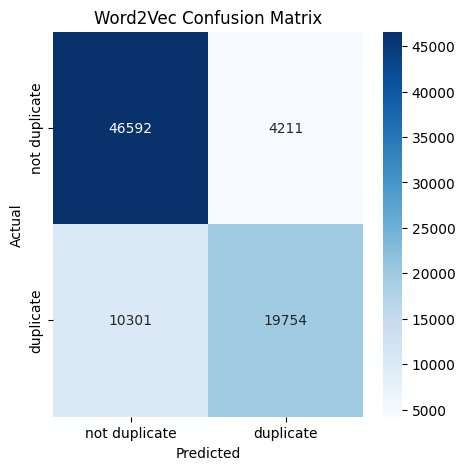

In [59]:
# Word2Vec confusion matrix
confusion_matrix_w2v = confusion_matrix(y_test_w2v, y_pred_w2v)
plot_confusion_matrix(confusion_matrix_w2v, title='Word2Vec Confusion Matrix')
